# Simple Neural Network for Image Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maheshghanta/Codes/blob/master/PyTorch_Tutorials/Tutorial1_Exercises/3.Simple_Neural_Network_Example_Exercise.ipynb)

This tutorial demonstrates building a **fully connected neural network** (no CNN) for CIFAR-10 image classification with:
- Complete training pipeline
- TensorBoard logging
- Metrics visualization

In [ ]:
%pip install torch torchvision
%pip install ipywidgets
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install scipy
%pip install -i https://test.pypi.org/simple/ exercise-validation==0.1.7

## Overview

We'll build a **Multi-Layer Perceptron (MLP)** - a fully connected neural network - to classify CIFAR-10 images.

**Key Components:**
- Input: Flattened 32×32×3 images (3072 features)
- Hidden layers: Fully connected layers with ReLU activation
- Output: 10 classes (CIFAR-10 categories)
- Training: Backpropagation with cross-entropy loss
- Logging: TensorBoard for monitoring training

## Setup and Imports

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0
CUDA available: False


In [9]:

from exercise_validation import (
    validate_mlp_exercise_1,
    validate_mlp_exercise_2,create_check_button,create_feedback
)

print("✓ Validation functions imported from exercise_validation package")

✓ Validation functions imported from exercise_validation package


## 1. Load and Prepare Data

In [4]:
# Define transforms
# We'll convert images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts PIL Image to tensor [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split training data into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(
    train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")

Training samples: 40000
Validation samples: 10000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

# Check data shape
sample_image, sample_label = next(iter(train_loader))
print(f"Batch shape: {sample_image.shape}")  # (batch_size, channels, height, width)
print(f"Label shape: {sample_label.shape}")
print(f"Image size per sample: {sample_image[0].shape}")
print(f"Flattened size: {sample_image[0].numel()} = 3*32*32 = 3072")

/Users/mghanta/Documents/Codes/Non_Core/ML_Demos/Codes/PyTorch_Tutorials/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch shape: torch.Size([128, 3, 32, 32])
Label shape: torch.Size([128])
Image size per sample: torch.Size([3, 32, 32])
Flattened size: 3072 = 3*32*32 = 3072


## 2. Define Neural Network Model

We'll create a Multi-Layer Perceptron (MLP) - a fully connected neural network without convolutions.

In [6]:
class SimpleMLP(nn.Module):
    """
    Simple Multi-Layer Perceptron for CIFAR-10 classification
    Architecture: Input(3072) -> Hidden1(512) -> Hidden2(256) -> Output(10)
    """
    
    def __init__(self, input_size=3072, hidden1_size=512, hidden2_size=256, num_classes=10):
        super(SimpleMLP, self).__init__()
        
        # Fully connected layers
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Flatten input: (batch_size, 3, 32, 32) -> (batch_size, 3072)
        x = x.view(x.size(0), -1)
        
        # Layer 1
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Layer 2
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        # Output layer (no activation, will use CrossEntropyLoss which includes softmax)
        x = self.fc3(x)
        
        return x

# Create model
model = SimpleMLP()
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

SimpleMLP(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
)

Total parameters: 1,707,274
Trainable parameters: 1,707,274


## 3. Setup Training Components

---
## 🎯 Exercise 1: Build MLP Architecture

**Task:** Complete the SimpleMLP forward method.

**Instructions:**
1. Flatten input: `x.view(x.size(0), -1)`
2. Apply fc1 → relu → dropout
3. Apply fc2 → relu → dropout  
4. Apply fc3 (no activation)
5. Return x


In [14]:
class MyMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # TODO: Implement forward pass
        # Step 1: Flatten
        x = None  # x.view(x.size(0), -1)
        
        # Step 2: fc1 -> relu -> dropout
        # x = ...
        
        # Step 3: fc2 -> relu -> dropout
        # x = ...
        
        # Step 4: fc3 (output layer)
        # x = ...
        
        return None  # Return x

my_mlp = MyMLP()
test_input = torch.randn(4, 3, 32, 32)
if my_mlp(test_input) is not None:
    print(f"Output shape: {my_mlp(test_input).shape}")
create_check_button("mlp_ex1", lambda: validate_mlp_exercise_1(my_mlp))

Button(button_style='primary', description='✓ Check Answer', icon='check', style=ButtonStyle(), tooltip='Click…

Output()

---
## 🎯 Exercise 2: Training Setup

**Task:** Setup loss function and optimizer.

**Instructions:**
- Create `criterion` = CrossEntropyLoss
- Create `optimizer` = Adam with lr=0.001


In [15]:
model_ex2 = MyMLP()

# TODO: Create loss function
my_criterion = None  # nn.CrossEntropyLoss()

# TODO: Create optimizer  
my_optimizer = None  # optim.Adam(model_ex2.parameters(), lr=0.001)

if my_criterion and my_optimizer:
    print(f"Criterion: {my_criterion}")
    print(f"Optimizer: {my_optimizer.__class__.__name__}")
    print(f"Learning rate: {my_optimizer.param_groups[0]['lr']}")
create_check_button("mlp_ex2", lambda: validate_mlp_exercise_2(my_criterion, my_optimizer))

Button(button_style='primary', description='✓ Check Answer', icon='check', style=ButtonStyle(), tooltip='Click…

Output()

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Loss function (CrossEntropyLoss includes softmax)
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam optimizer)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Learning rate: {optimizer.param_groups[0]['lr']}")

Using device: cpu
Loss function: CrossEntropyLoss()
Optimizer: Adam
Learning rate: 0.001


## 4. Setup TensorBoard Logging

In [17]:
# Create TensorBoard writer with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_dir = f'runs/mlp_cifar10_{timestamp}'
writer = SummaryWriter(log_dir)

print(f"TensorBoard logs saved to: {log_dir}")
print(f"To view: tensorboard --logdir=runs")

# Log model architecture
sample_input = torch.randn(1, 3, 32, 32).to(device)
writer.add_graph(model, sample_input)
print("Model graph added to TensorBoard")

TensorBoard logs saved to: runs/mlp_cifar10_20251104_171538
To view: tensorboard --logdir=runs
Model graph added to TensorBoard


## 5. Training Functions

In [18]:
def train_one_epoch(model, loader, criterion, optimizer, device, epoch, writer):
    """
    Train the model for one epoch
    
    Returns:
        average_loss: Average training loss
        accuracy: Training accuracy (%)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (images, labels) in enumerate(loader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # Log batch metrics to TensorBoard
        if batch_idx % 100 == 0:
            writer.add_scalar('Train/BatchLoss', loss.item(), epoch * len(loader) + batch_idx)
            batch_acc = 100. * correct / total
            writer.add_scalar('Train/BatchAccuracy', batch_acc, epoch * len(loader) + batch_idx)
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    
    return avg_loss, accuracy


@torch.no_grad()
def validate(model, loader, criterion, device, epoch, writer, phase='Validation'):
    """
    Validate the model
    
    Returns:
        average_loss: Average validation loss
        accuracy: Validation accuracy (%)
        all_preds: All predictions
        all_labels: All true labels
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = running_loss / len(loader)
    accuracy = 100. * correct / total
    
    # Log epoch metrics to TensorBoard
    writer.add_scalar(f'{phase}/Loss', avg_loss, epoch)
    writer.add_scalar(f'{phase}/Accuracy', accuracy, epoch)
    
    return avg_loss, accuracy, all_preds, all_labels

print("Training functions defined successfully!")

Training functions defined successfully!


## 6. Training Loop

In [19]:
# Training configuration
num_epochs = 20
best_val_acc = 0.0

# Store metrics for plotting
train_losses = []
train_accs = []
val_losses = []
val_accs = []

print(f"Starting training for {num_epochs} epochs...")
print("=" * 80)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 80)
    
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch, writer
    )
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate(
        model, val_loader, criterion, device, epoch, writer, 'Validation'
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    writer.add_scalar('Train/LearningRate', current_lr, epoch)
    
    # Store metrics
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Print epoch summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"Learning Rate: {current_lr}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
        }, 'best_model.pth')
        print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

print("\n" + "=" * 80)
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
writer.close()

Starting training for 20 epochs...

Epoch 1/20
--------------------------------------------------------------------------------


/Users/mghanta/Documents/Codes/Non_Core/ML_Demos/Codes/PyTorch_Tutorials/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.7558 | Train Acc: 37.69%
Val Loss: 1.5876 | Val Acc: 44.26%
Learning Rate: 0.001
✓ Best model saved! (Val Acc: 44.26%)

Epoch 2/20
--------------------------------------------------------------------------------
Train Loss: 1.5786 | Train Acc: 44.42%
Val Loss: 1.5185 | Val Acc: 45.96%
Learning Rate: 0.001
✓ Best model saved! (Val Acc: 45.96%)

Epoch 3/20
--------------------------------------------------------------------------------
Train Loss: 1.5032 | Train Acc: 46.78%
Val Loss: 1.4599 | Val Acc: 48.71%
Learning Rate: 0.001
✓ Best model saved! (Val Acc: 48.71%)

Epoch 4/20
--------------------------------------------------------------------------------
Train Loss: 1.4396 | Train Acc: 49.08%
Val Loss: 1.4513 | Val Acc: 48.67%
Learning Rate: 0.001

Epoch 5/20
--------------------------------------------------------------------------------
Train Loss: 1.3927 | Train Acc: 50.47%
Val Loss: 1.4426 | Val Acc: 49.65%
Learning Rate: 0.001
✓ Best model saved! (Val Acc: 49.65%)



## 7. Plot Training Metrics

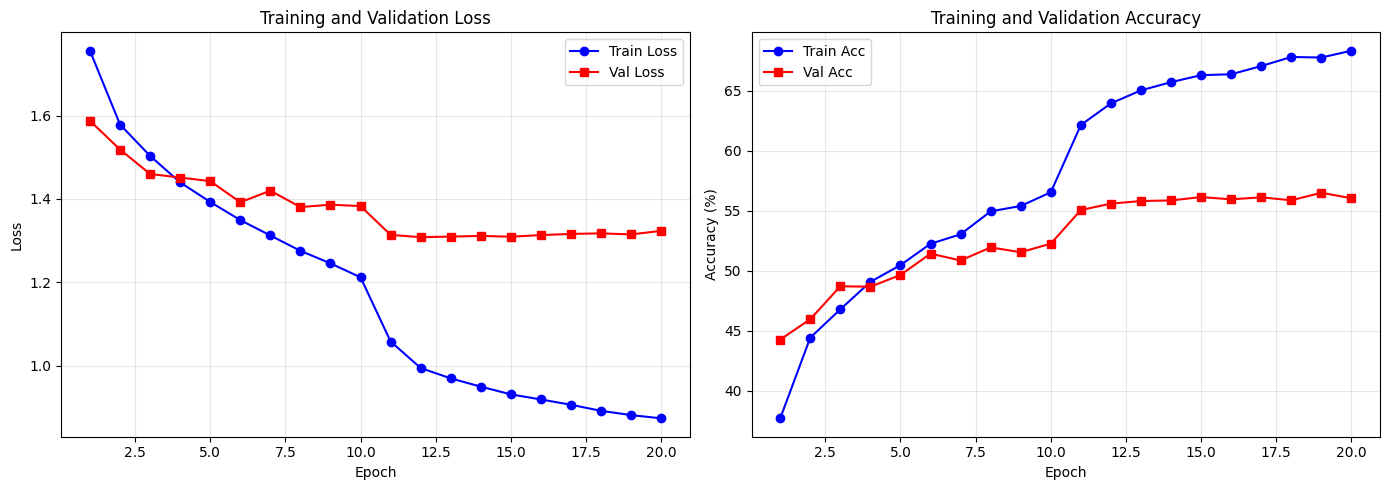

Training curves saved to 'training_curves.png'


In [20]:
# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(range(1, num_epochs+1), train_losses, 'b-', label='Train Loss', marker='o')
axes[0].plot(range(1, num_epochs+1), val_losses, 'r-', label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(range(1, num_epochs+1), train_accs, 'b-', label='Train Acc', marker='o')
axes[1].plot(range(1, num_epochs+1), val_accs, 'r-', label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Training curves saved to 'training_curves.png'")

## 8. Test Set Evaluation

In [10]:
# Load best model
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = validate(
    model, test_loader, criterion, device, 0, writer, 'Test'
)

print("\n" + "=" * 80)
print("TEST SET RESULTS")
print("=" * 80)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print("=" * 80)

Loaded best model from epoch 16

TEST SET RESULTS
Test Loss: 1.3299
Test Accuracy: 55.22%


## 9. Per-Class Accuracy


Per-Class Accuracy:
----------------------------------------
airplane    :  62.70% (627/1000)
automobile  :  66.80% (668/1000)
bird        :  38.10% (381/1000)
cat         :  39.30% (393/1000)
deer        :  49.20% (492/1000)
dog         :  41.20% (412/1000)
frog        :  63.60% (636/1000)
horse       :  61.10% (611/1000)
ship        :  69.30% (693/1000)
truck       :  60.90% (609/1000)


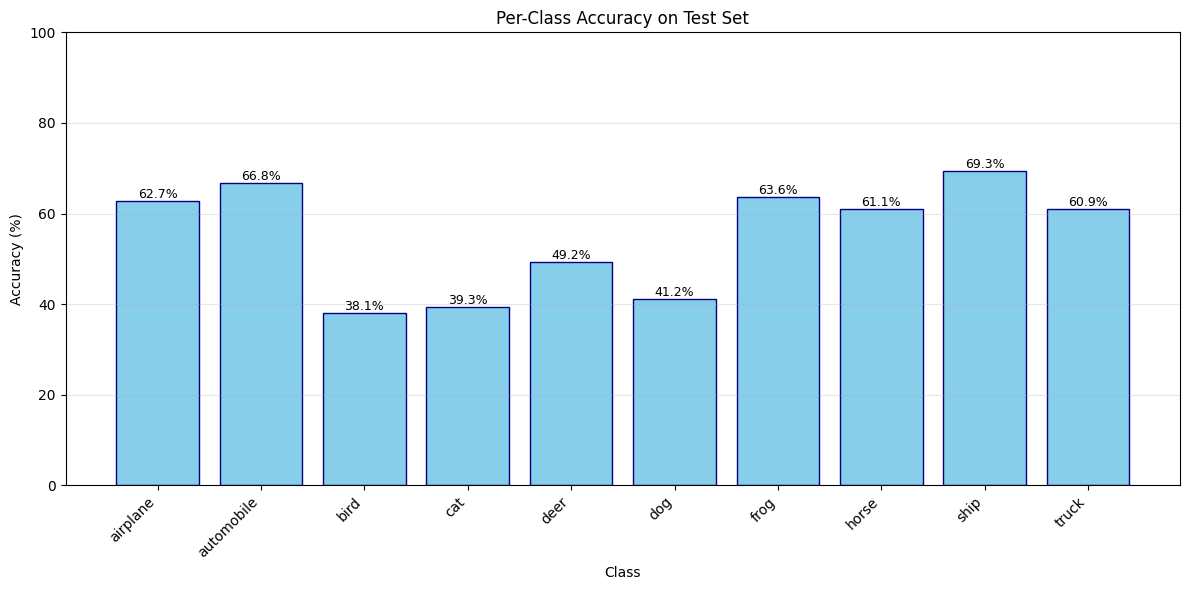


Per-class accuracy plot saved to 'per_class_accuracy.png'


In [11]:
# Calculate per-class accuracy
from collections import defaultdict

class_correct = defaultdict(int)
class_total = defaultdict(int)

for pred, label in zip(test_preds, test_labels):
    if pred == label:
        class_correct[label] += 1
    class_total[label] += 1

classes = test_dataset.classes

print("\nPer-Class Accuracy:")
print("-" * 40)
class_accs = []
for i, class_name in enumerate(classes):
    acc = 100.0 * class_correct[i] / class_total[i]
    class_accs.append(acc)
    print(f"{class_name:12s}: {acc:6.2f}% ({class_correct[i]}/{class_total[i]})")

# Plot per-class accuracy
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(classes)), class_accs, color='skyblue', edgecolor='navy')
plt.xlabel('Class')
plt.ylabel('Accuracy (%)')
plt.title('Per-Class Accuracy on Test Set')
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')
plt.ylim([0, 100])
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, acc in zip(bars, class_accs):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nPer-class accuracy plot saved to 'per_class_accuracy.png'")

## 10. Confusion Matrix

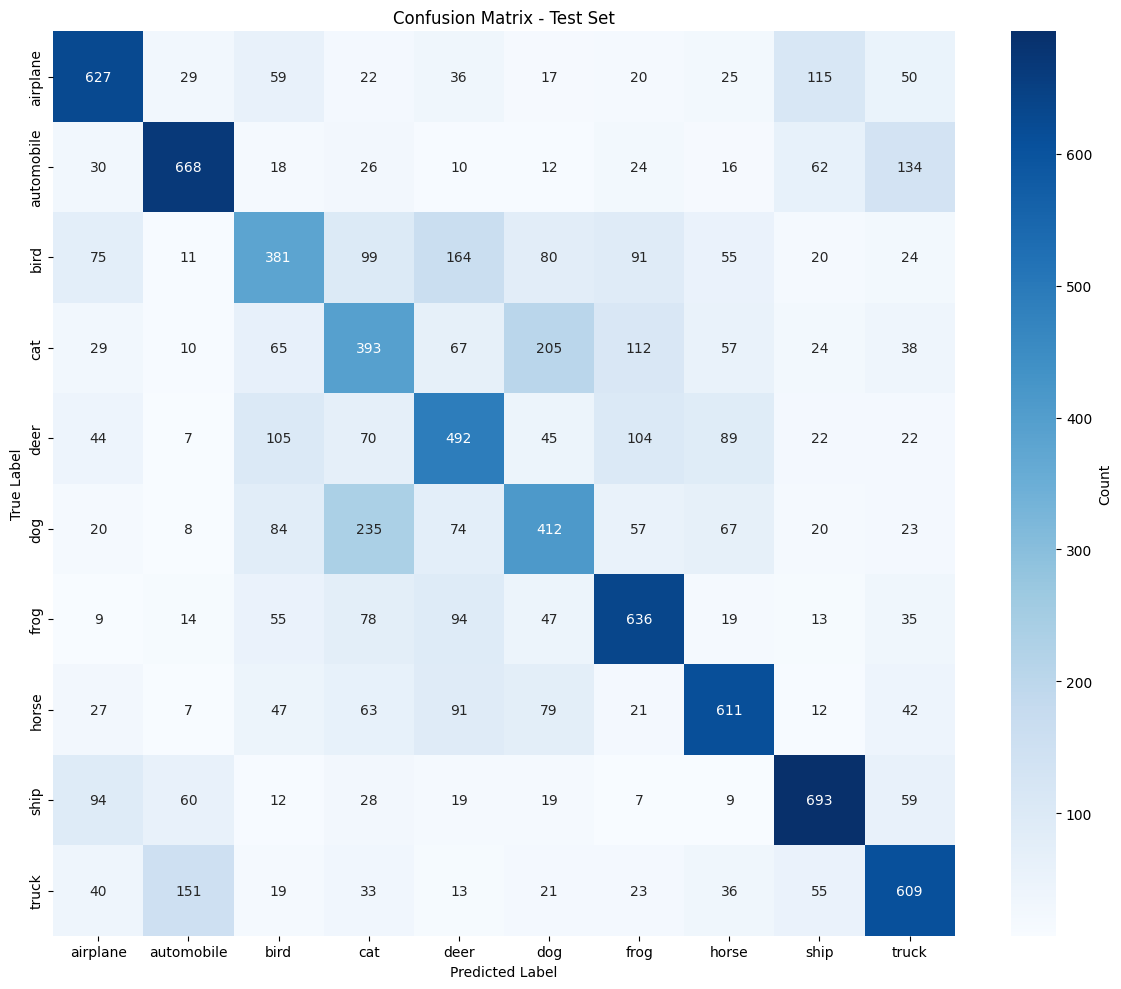

Confusion matrix saved to 'confusion_matrix.png'


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("Confusion matrix saved to 'confusion_matrix.png'")

## 11. Sample Predictions

/Users/mghanta/Documents/Codes/Non_Core/ML_Demos/ml-model-development/Pytorch_Tutorials/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


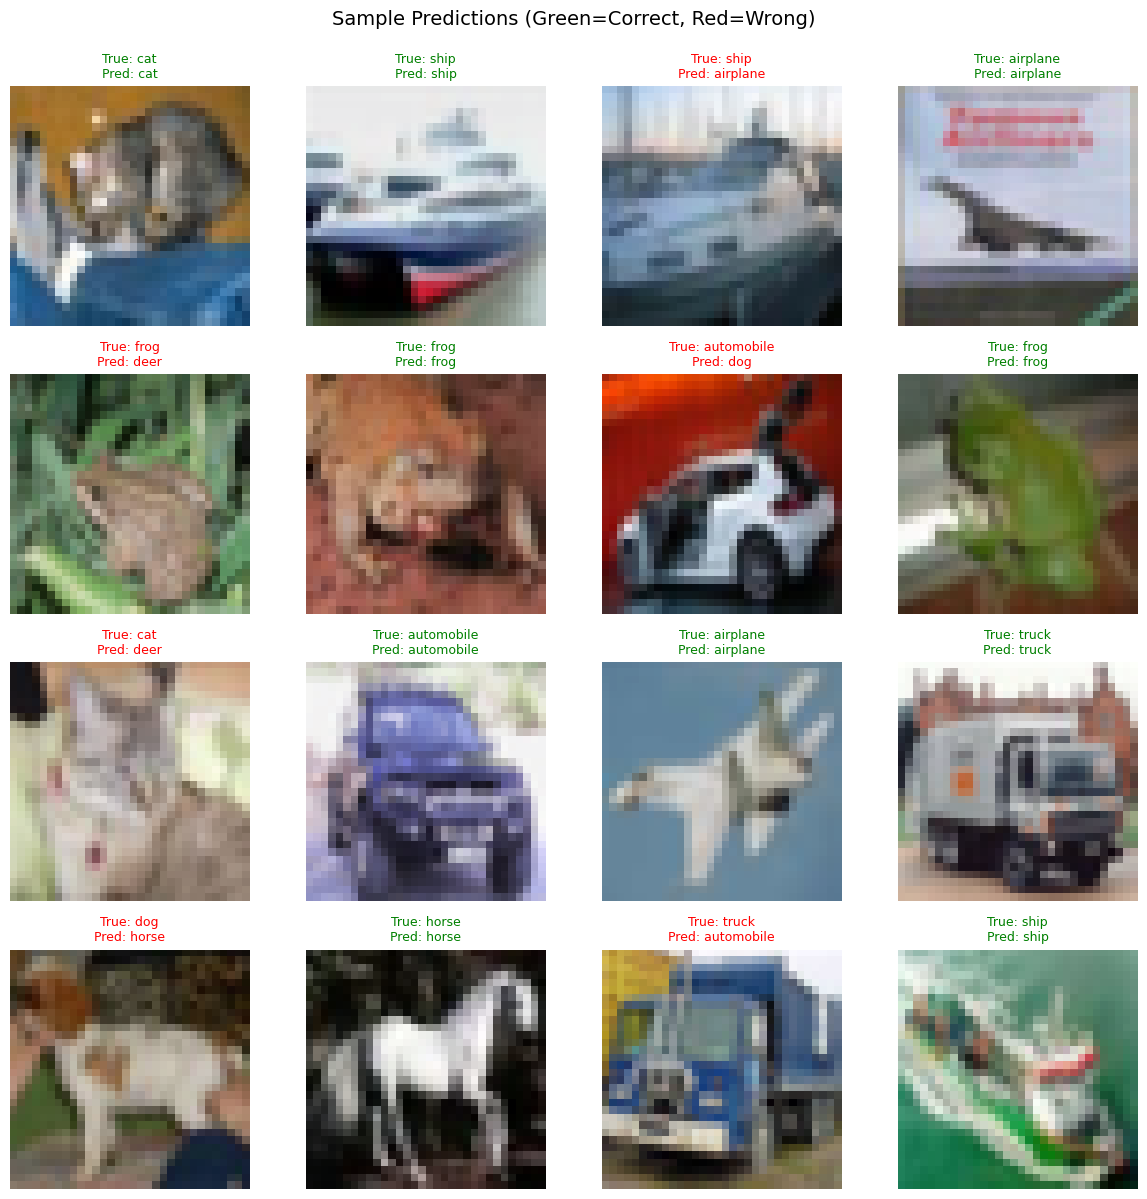

Sample predictions saved to 'sample_predictions.png'


In [14]:
# Get a batch of test images
model.eval()
test_images, test_labels_batch = next(iter(test_loader))
test_images = test_images.to(device)

with torch.no_grad():
    outputs = model(test_images)
    _, predictions = outputs.max(1)

# Move to CPU for visualization
test_images = test_images.cpu()
predictions = predictions.cpu()

# Visualize first 16 predictions
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    # Denormalize image
    img = test_images[i].permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    
    # Color: green if correct, red if wrong
    true_label = classes[test_labels_batch[i]]
    pred_label = classes[predictions[i]]
    color = 'green' if test_labels_batch[i] == predictions[i] else 'red'
    
    ax.set_title(f'True: {true_label}\nPred: {pred_label}', color=color, fontsize=9)
    ax.axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Wrong)', fontsize=14, y=0.995)
plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Sample predictions saved to 'sample_predictions.png'")